In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import lightgbm as lgb




from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from time import time
import duckdb
# %load_ext sql
# %config SqlMagic.autopandas = True
# %config SqlMagic.feedback = False
# %config SqlMagic.displaycon = False
# %sql duckdb:///:memory:
import time
import optuna
from optuna.study import MaxTrialsCallback
from optuna.trial import TrialState

from optuna.visualization import plot_param_importances, plot_contour,  plot_slice, plot_optimization_history
import plotly.express as px
import os

import kaggle 
import glob


In [117]:

ganancia_acierto = 273000
costo_estimulo = 7000

In [118]:
df = pd.read_csv(r'c:\Users\Admin\Documents\1_Notebook\1_Estudio\1_UBA_Maestria_DS\1_Especializacion\1_Segundo_Semestre\DMEyF\datasets\competencia_2\competencia_02_ct.csv')

In [119]:
def psi(expected, actual, buckets=10):

    def psi_formula(expected_prop, actual_prop):
        result = (actual_prop - expected_prop) * np.log(actual_prop / expected_prop)
        return result

    expected_not_null = expected.dropna()
    actual_not_null = actual.dropna()

    bin_edges = pd.qcut(expected_not_null, q=buckets, duplicates='drop').unique()
    bin_edges2 = [edge.left for edge in bin_edges] + [edge.right for edge in bin_edges]
    breakpoints = sorted(list(set(bin_edges2)))

    expected_counts, _ = np.histogram(expected_not_null, bins=breakpoints)
    actual_counts, _ = np.histogram(actual_not_null, bins=breakpoints)

    expected_prop = expected_counts / len(expected_not_null)
    actual_prop = actual_counts / len(actual_not_null)

    psi_not_null = psi_formula(expected_prop, actual_prop).sum()

    psi_null = 0

    if expected.isnull().sum() > 0 and actual.isnull().sum() > 0 :
      expected_null_percentage = expected.isnull().mean()
      actual_null_percentage = actual.isnull().mean()
      psi_null = psi_formula(expected_null_percentage, actual_null_percentage)

    return psi_not_null + psi_null


In [120]:
df['foto_mes'].value_counts()

foto_mes
202108    165442
202107    165152
202106    164876
202105    164623
202104    164090
202103    163685
202102    162646
202101    162026
202012    161526
202011    160742
202010    159731
202009    158371
202008    157058
202007    155764
202006    153757
202005    151261
202004    149872
202003    149356
202002    147109
202001    143966
201912    140661
201911    138667
201910    136682
201909    134314
201908    132664
201907    130724
201906    129186
201905    127659
201904    126996
201903    126436
201902    125799
201901    124752
Name: count, dtype: int64

In [121]:
train_data = df[df['foto_mes']>202105]
score_data = df[df['foto_mes']==202107]


## Nulls

In [136]:
## Nulls

train_null_percentage = train_data.isnull().mean() * 100
score_null_percentage = score_data.isnull().mean() * 100

comparison_df = pd.DataFrame({'Train Null Percentage': train_null_percentage, 'Score Null Percentage': score_null_percentage})
comparison_df['diff'] = (comparison_df['Score Null Percentage'] - comparison_df['Train Null Percentage']).abs()

comparison_df_sorted = comparison_df.sort_values('diff', ascending=False)

comparison_df_sorted

,Train Null Percentage,Score Null Percentage,diff
clase_peso,32.875653,0.000000,32.875653
Visa_Finiciomora,98.763800,99.409029,0.645229
mtarjeta_visa_descuentos,2.115365,2.696910,0.581544
Master_fultimo_cierre,10.012513,9.628706,0.383808
Visa_mpagospesos,12.772721,12.392220,0.380500
...,...,...,...
mpayroll,0.000000,0.000000,0.000000
mpayroll2,0.000000,0.000000,0.000000
cpayroll2_trx,0.000000,0.000000,0.000000
ccuenta_debitos_automaticos,0.000000,0.000000,0.000000


In [ ]:
df_train

## PSI

In [ ]:
df

In [122]:
psi_results = []
for column in train_data.columns:
  if column not in ['foto_mes', 'clase_ternaria']:
    train_variable = train_data[column]
    score_variable = score_data[column]
    psi_value = psi(train_variable, score_variable)
    psi_results.append({'feature': column, 'psi': psi_value})

psi_df = pd.DataFrame(psi_results)
psi_df = psi_df.sort_values('psi', ascending=False)
pd.reset_option('display.max_rows')
psi_df.head(10)

C:\Users\Admin\AppData\Local\Temp\ipykernel_31568\2860382255.py:4: RuntimeWarning:

divide by zero encountered in log

C:\Users\Admin\AppData\Local\Temp\ipykernel_31568\2860382255.py:4: RuntimeWarning:

divide by zero encountered in log

C:\Users\Admin\AppData\Local\Temp\ipykernel_31568\2860382255.py:4: RuntimeWarning:

divide by zero encountered in log



,feature,psi
113,Master_Finiciomora,inf
144,Visa_fultimo_cierre,inf
122,Master_fultimo_cierre,inf
135,Visa_Finiciomora,1.807091
71,mcomisiones_mantenimiento,0.022979
145,Visa_mpagado,0.021499
50,cpayroll_trx,0.019965
51,mpayroll,0.017180
17,mcaja_ahorro,0.009922
10,mpasivos_margen,0.007197


In [123]:
def psi(expected, actual, buckets=10):

    def psi_formula(expected_prop, actual_prop):
        result = (actual_prop - expected_prop) * np.log(actual_prop / expected_prop)
        return result

    expected_not_null = expected.dropna()
    actual_not_null = actual.dropna()

    bin_edges = pd.qcut(expected_not_null, q=buckets, duplicates='drop').unique()
    bin_edges2 = [edge.left for edge in bin_edges] + [edge.right for edge in bin_edges]
    breakpoints = sorted(list(set(bin_edges2)))

    expected_counts, _ = np.histogram(expected_not_null, bins=breakpoints)
    actual_counts, _ = np.histogram(actual_not_null, bins=breakpoints)

    expected_prop = expected_counts / len(expected_not_null)
    actual_prop = actual_counts / len(actual_not_null)

    psi_not_null = psi_formula(expected_prop, actual_prop).sum()

    psi_null = 0

    if expected.isnull().sum() > 0 and actual.isnull().sum() > 0 :
      expected_null_percentage = expected.isnull().mean()
      actual_null_percentage = actual.isnull().mean()
      psi_null = psi_formula(expected_null_percentage, actual_null_percentage)

    return psi_not_null + psi_null


In [124]:
psi_results = []
for column in train_data.columns:
  if column not in ['foto_mes', 'clase_ternaria']:
    train_variable = train_data[column]
    score_variable = score_data[column]
    psi_value = psi(train_variable, score_variable)
    psi_results.append({'feature': column, 'psi': psi_value})

psi_df = pd.DataFrame(psi_results)
psi_df = psi_df.sort_values('psi', ascending=False)
psi_df.head(10)

C:\Users\Admin\AppData\Local\Temp\ipykernel_31568\2860382255.py:4: RuntimeWarning:

divide by zero encountered in log

C:\Users\Admin\AppData\Local\Temp\ipykernel_31568\2860382255.py:4: RuntimeWarning:

divide by zero encountered in log

C:\Users\Admin\AppData\Local\Temp\ipykernel_31568\2860382255.py:4: RuntimeWarning:

divide by zero encountered in log



,feature,psi
113,Master_Finiciomora,inf
144,Visa_fultimo_cierre,inf
122,Master_fultimo_cierre,inf
135,Visa_Finiciomora,1.807091
71,mcomisiones_mantenimiento,0.022979
145,Visa_mpagado,0.021499
50,cpayroll_trx,0.019965
51,mpayroll,0.017180
17,mcaja_ahorro,0.009922
10,mpasivos_margen,0.007197


In [125]:
variables_considerables = psi_df.query('psi>0.2 & psi<10')['feature'].tolist()
variables_considerables

['Visa_Finiciomora']

In [126]:
variable_name = 'Visa_Finiciomora'
expected = train_data[variable_name]
actual = score_data[variable_name]

expected_not_null = expected.dropna()
actual_not_null = actual.dropna()

bin_edges = pd.qcut(expected_not_null, q=20, duplicates='drop').unique()
bin_edges2 = [edge.left for edge in bin_edges] + [edge.right for edge in bin_edges]
breakpoints = sorted(list(set(bin_edges2)))

print(f'Cortes en {variable_name}: {breakpoints}')
expected_counts, _ = np.histogram(expected_not_null, bins=breakpoints)
actual_counts, _ = np.histogram(actual_not_null, bins=breakpoints)

print(f'Frecuencia Esperada: {expected_counts}')
print(f'Frecuencia Actual: {actual_counts}')

Cortes en Visa_Finiciomora: [-0.001, 13.0, 20.0, 22.0, 23.0, 24.0, 27.0, 51.0, 55.0, 83.0, 331.0]
Frecuencia Esperada: [3287  205  473   37  465  389  323  315  310  321]
Frecuencia Actual: [  4 128 443   0   0   8 100  19 171 103]


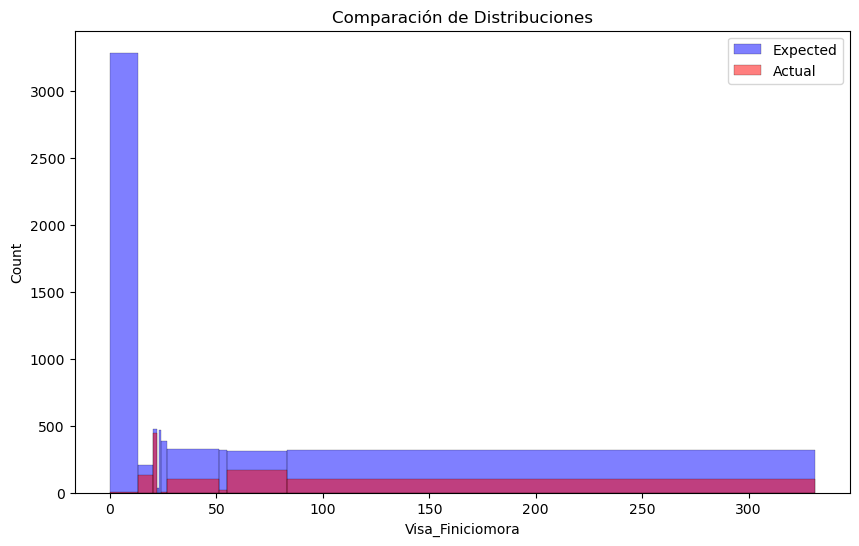

In [127]:
plt.figure(figsize=(10, 6))
sns.histplot(data=expected_not_null, bins=breakpoints, alpha=0.5, label='Expected', color='blue')
sns.histplot(data=actual_not_null, bins=breakpoints, alpha=0.5, label='Actual', color='red')
plt.legend()
plt.title('Comparación de Distribuciones')
plt.show()


In [128]:
params = {
'objective': 'binary',  # Puedes cambiar esto si tu problema es multiclase u otro tipo
'metric': 'binary_logloss',  # Cambia el metric si es necesario
'seed': 42 }

df.loc[df['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
df.loc[df['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

df['clase_ternaria'] = np.where(df['clase_ternaria'] == 'CONTINUA',0,1)

train_data = df[df['foto_mes']>202105]
score_data = df[df['foto_mes']==202107]

X_train = train_data.drop(columns=['clase_ternaria'])
Y_train = train_data['clase_ternaria']
w_train = train_data['clase_peso']


X_test = score_data.drop(columns=['clase_ternaria'])
Y_test = score_data['clase_ternaria']
w_test = score_data['clase_peso']

train_data_post = lgb.Dataset(X_train,
                label= Y_train,
                weight=w_train)



In [129]:
df['clase_ternaria'].value_counts()

clase_ternaria
0    3768917
1     966676
Name: count, dtype: int64

In [130]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

In [131]:

model = lgb.train(params, train_data_post)
data_test_post = lgb.Dataset(X_test, label=Y_test, weight=w_test)

y_pred = model.predict(X_test)
lgb_gan_eval(y_pred, data_test_post)

[LightGBM] [Info] Number of positive: 332581, number of negative: 162889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20630
[LightGBM] [Info] Number of data points in the train set: 495470, number of used features: 155
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leav

('gan_eval', 2147481000, True)

In [132]:
lgb_gan_eval(y_pred, data_test_post)

('gan_eval', 2147481000, True)

In [ ]:
2147481000

In [135]:
variables_considerables

['Visa_Finiciomora']

In [142]:
variables_considerables

['Visa_Finiciomora']

In [143]:
from sklearn.preprocessing import PowerTransformer

for variable in variables_considerables:
  
    expected = train_data[variable].dropna().values.reshape(-1, 1)
    actual = score_data[variable].dropna().values.reshape(-1, 1)

    pt = PowerTransformer(method='yeo-johnson')
    expected_transformed = pt.fit_transform(expected)
    actual_transformed = pt.transform(actual+1)

    print(f"Transformación completada para la variable {variable}")


Transformación completada para la variable Visa_Finiciomora


In [144]:

X_train = train_data.drop(columns=['clase_ternaria'])
Y_train = train_data['clase_ternaria']
w_train = train_data['clase_peso']


X_test = score_data.drop(columns=['clase_ternaria'])
Y_test = score_data['clase_ternaria']
w_test = score_data['clase_peso']

train_data_post = lgb.Dataset(X_train,
                label= Y_train,
                weight=w_train)
model = lgb.train(params, train_data_post)
data_test_post = lgb.Dataset(X_test, label=Y_test, weight=w_test)

y_pred = model.predict(X_test)


[LightGBM] [Info] Number of positive: 332581, number of negative: 162889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20630
[LightGBM] [Info] Number of data points in the train set: 495470, number of used features: 155
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [145]:
lgb_gan_eval(y_pred, data_test_post)

('gan_eval', 2147481000, True)

Cortes en Visa_Finiciomora: [-0.001, 13.0, 20.0, 22.0, 23.0, 24.0, 27.0, 51.0, 55.0, 83.0, 331.0]
Frecuencia Esperada: [3287  205  473   37  465  389  323  315  310  321]
Frecuencia Actual: [  4 128 443   0   0   8 100  19 171 103]


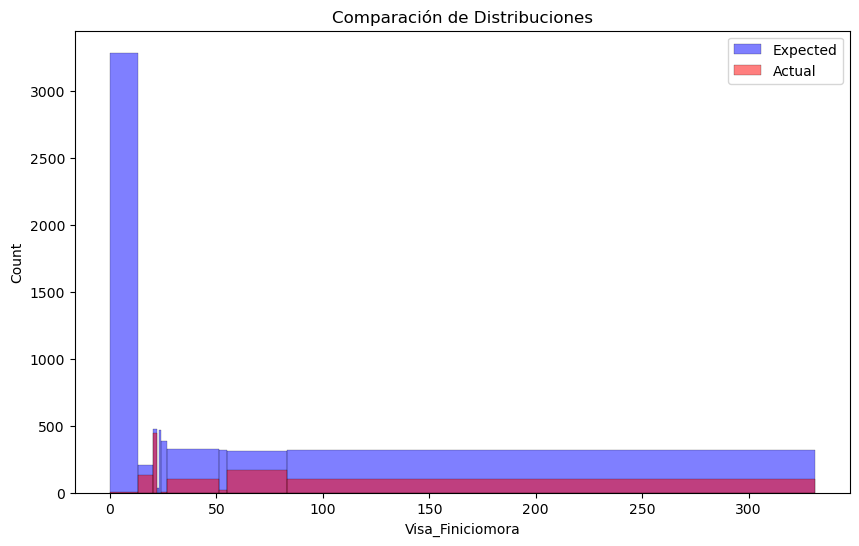

In [146]:
variable_name = 'Visa_Finiciomora'
expected = train_data[variable_name]
actual = score_data[variable_name]

expected_not_null = expected.dropna()
actual_not_null = actual.dropna()

bin_edges = pd.qcut(expected_not_null, q=20, duplicates='drop').unique()
bin_edges2 = [edge.left for edge in bin_edges] + [edge.right for edge in bin_edges]
breakpoints = sorted(list(set(bin_edges2)))

print(f'Cortes en {variable_name}: {breakpoints}')
expected_counts, _ = np.histogram(expected_not_null, bins=breakpoints)
actual_counts, _ = np.histogram(actual_not_null, bins=breakpoints)

print(f'Frecuencia Esperada: {expected_counts}')
print(f'Frecuencia Actual: {actual_counts}')
plt.figure(figsize=(10, 6))
sns.histplot(data=expected_not_null, bins=breakpoints, alpha=0.5, label='Expected', color='blue')
sns.histplot(data=actual_not_null, bins=breakpoints, alpha=0.5, label='Actual', color='red')
plt.legend()
plt.title('Comparación de Distribuciones')
plt.show()